Clémence GRISLAIN

clemence.grislain@eleves.enpc.fr

# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [4]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend, plot_edges_and_points
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy

c:\Users\cgris\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


## Generating the data

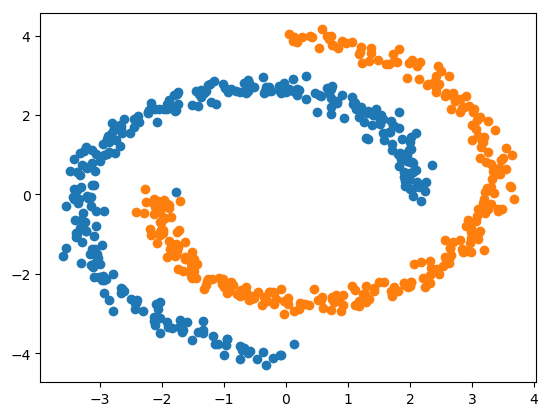

Signature: worst_case_blob(num_samples, delta=5)
Docstring:
Generates a single blob.

:param num_samples: number of samples to create in the blob
:param delta:
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      c:\users\cgris\onedrive\documents\enpc\4a 2022-2023\s2\graph in ml\spectral_clustering\generate_data.py
Type:      function


In [204]:
# Example

for fn in [two_moons]:  #  try also [two_moons, worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))

plt.show()
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [5]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0, rule='OR'):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    similarities = np.zeros((n, n))

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        for i in range(n):
            for j in range(n):
                w = np.exp(-np.linalg.norm(X[i] - X[j])**2 / (2 * var**2))
                if np.abs(w) >= eps:
                    W[i, j] = w

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        for i in range(n):
            weights = np.zeros(n)
            for j in range(n):
                w = np.exp(-np.linalg.norm(X[i] - X[j])**2 / (2 * var**2))
                weights[j] = w
            for j in np.argsort(-weights)[1:k+1]:
                W[i, j] = weights[j]
                if rule=="OR":
                    W[j, i] = weights[j]

        if rule=="AND":
            for i in range(n):
                for j in range(n):
                    w = min(W[i,j], W[j,i])
                    W[i,j] = w
                    W[j,i] = w
    return W


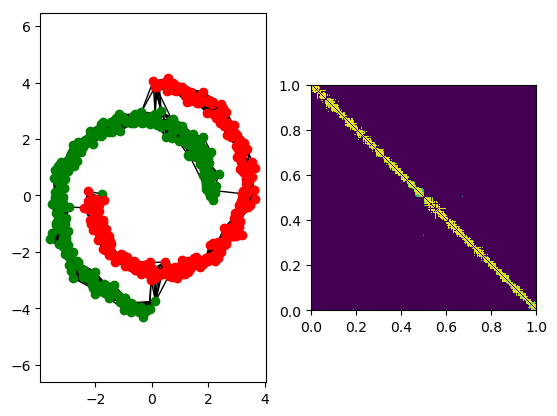

In [212]:
# Example

W = build_similarity_graph(X, k=20)
W[0, 599] = 1    # add two placeholder edges to reproduce example picture
W[10, 500] = 1   # 

plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [6]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    D = np.diag(W.sum(axis=1))
    L = D - W
    if laplacian_normalization=="unn":
        return L
    if laplacian_normalization=="sym":
        inv_sqrt_D = np.linalg.inv(np.sqrt(D))
        return inv_sqrt_D @ L @ inv_sqrt_D
    if laplacian_normalization=="rw":
        return np.linalg.inv(D) @ L

## Clustering

In [7]:
# Return the index of the gap in max_idx fist values of sample
def identify_gap(sample, max_idx):
    gaps = sample[1:max_idx+1] - sample[:max_idx]
    gap_idx = np.argmax(gaps)
    return gap_idx
    

In [8]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2, tol=1e-8):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix  (sorted)
    E = (n x 1) eigenvalue vector   (sorted)
    """
    eig_values, eig_vectors = scipy.linalg.eig(L)
    sort_idx = np.argsort(eig_values)
    U = np.real(eig_vectors[:, sort_idx])
    E = np.real(eig_values[sort_idx])

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    if chosen_eig_indices==None:
        gap_idx =identify_gap(E, num_classes+1)
        idxs = np.arange(0, gap_idx+2)
    else:
        idxs = chosen_eig_indices

    Y = KMeans(num_classes).fit_predict(U[:,idxs])
    return Y

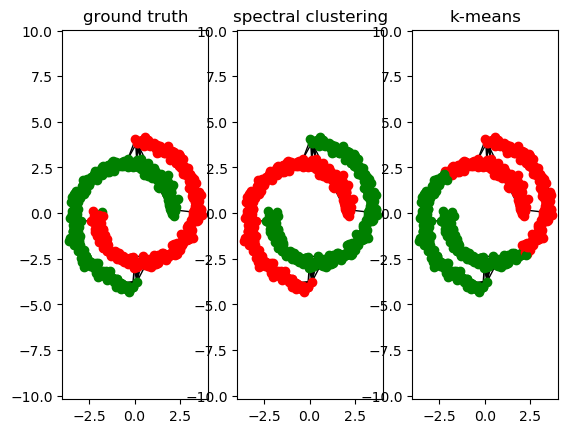

In [216]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [9]:
from utils import plot_edges_and_points

def parameter_sensitivity(parameter_type):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = ['unn', 'rw', 'sym']
    colors = ["magenta", "blue", "red"]
    chosen_eig_indices = None

    """
    Choose candidate parameters
    """
    if parameter_type == 'eps': # choose between 'k' or 'eps'
        parameter_candidate = np.linspace(0.1, .90, 10)
    if parameter_type == 'k':
        parameter_candidate = np.arange(1, 80, 2)  # the number of neighbours for the graph (if 'k')
                                  # or the epsilon threshold (if 'eps')

    fig = plt.figure(figsize=(20,8))

    for f, fn in enumerate([two_moons, worst_case_blob, point_and_circle, blobs]):
        fig.add_subplot(1, 4, f+1)

        for j, norm_lap in enumerate(laplacian_normalization):
            parameter_performance = []
            
            for i, parameter in enumerate(parameter_candidate):
                # Generate data
                X, Y = fn(num_samples)
                num_classes = len(np.unique(Y))
                
                parameter_wrap = {parameter_type: parameter}
                
                W = build_similarity_graph(X, **parameter_wrap)
                L = build_laplacian(W, norm_lap)

                Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

                #fig.add_subplot(2, len(parameter_candidate)//2 + 1, i+1)
                #plot_edges_and_points(X, Y_rec, W, title="{}={}".format(parameter_type, np.round(parameter, 2)))

                parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

            plt.plot(parameter_candidate, parameter_performance, c=colors[j], label=norm_lap)
            plt.title(str(fn.__name__))
            plt.ylabel("ajusted rand score")
            plt.legend()
    plt.suptitle(f'parameter sensitivity ({parameter_type})')
    plt.show()

## Image segmentation

In [11]:
def image_segmentation(k, num_classes, input_img='four_elements.bmp', laplacian_normalization="sym"):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    var = 1.0

    #for k in parameters:
    chosen_eig_indices = None
    
    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

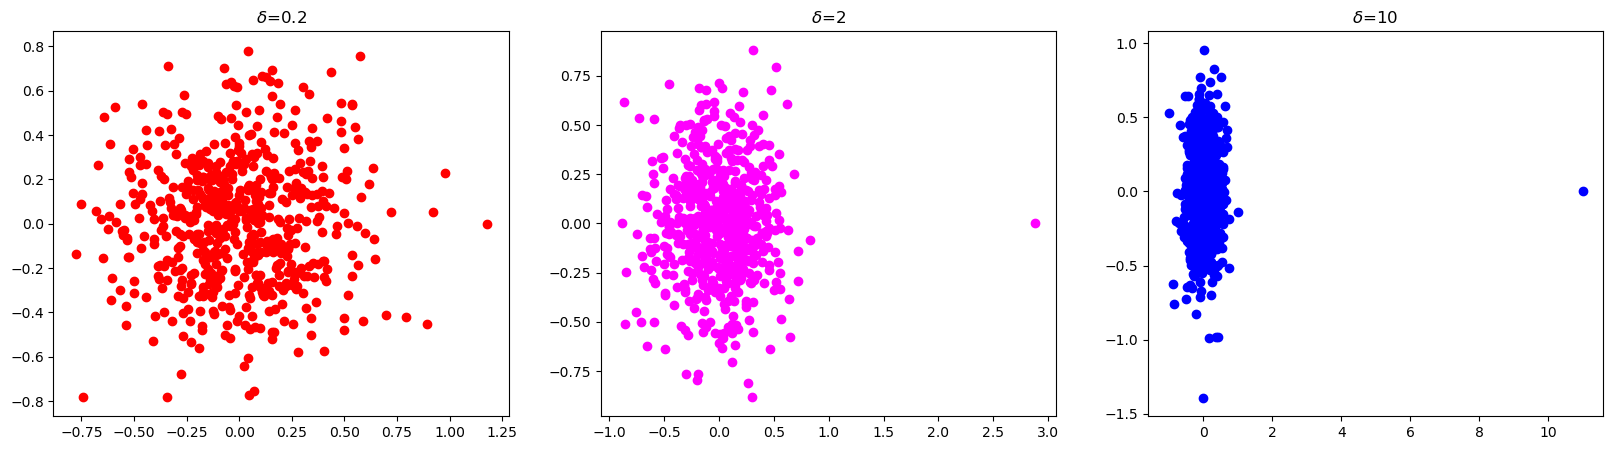

In [15]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,3,1)
X, Y = worst_case_blob(num_samples=600, delta=0.2)
plt.scatter(X[:,0], X[:,1], c='red')
plt.title('$\delta$=0.2')

fig.add_subplot(1,3,2)
X, Y = worst_case_blob(num_samples=600, delta=2)
plt.scatter(X[:,0], X[:,1], c='magenta')
plt.title('$\delta$=2')

fig.add_subplot(1,3,3)
X, Y = worst_case_blob(num_samples=600, delta=10)
plt.scatter(X[:,0], X[:,1], c='blue')
plt.title('$\delta$=10')

plt.show()

**Answers Q1.1**

The worst_case_blob is a blob with one outlier. The optional parameter delta fixes the distance between the blob and the outlier.

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

In [16]:
min_span_tree?

Signature: min_span_tree(W)
Docstring:
:param W: (n x n) adjacency matrix representing the graph
:return: T: (n x n) matrix such that T[i,j] = True if the edge (i, j) is in the min spanning tree, and
            T[i, j] = False otherwise
File:      c:\users\cgris\onedrive\documents\enpc\4a 2022-2023\s2\graph in ml\spectral_clustering\utils.py
Type:      function


**Answers Q1.2**

The MST is a subset of edges which together connect all connected nodes, while minimizing the total sum of weights on the edges. A way to ensure connectivity is to find epsilon such that the thresholded tree contains the MST.

To do that, we compute the MST on the fully connected Euclidian distance matrix (to avoid weights too close to zero in minus the similarity matrix) in order to keep smallest distances i.e. the most similar connections. If we use a threhold $\epsilon=min\{w_{ij} : (i,j)\in MST\}$, all the edges in the MST will remain in the threholded graph, hence ensuring connectivity.

As delta increases, the maximal threshold ensuring connectivity tends to 0.

This is not a good idea to use this approach because delta can be as big as we want. Thus, the only value ensuring connectivity for all parameters delta is epsilon equals 0.0, equivalent to no threshold and fully connected graph.

In [17]:
def eps_MST_W(X):
    n_samples = X.shape[0]
    W = build_similarity_graph(X)

    # Compute the MST on the Euclidian distance matrix
    dist = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            dist[i,j] = np.linalg.norm(X[i] - X[j])
    tree = min_span_tree(dist)

    # Get the threshold epsilon
    idx = np.where(tree)
    eps = np.min(W[idx[0], idx[1]])
    return eps

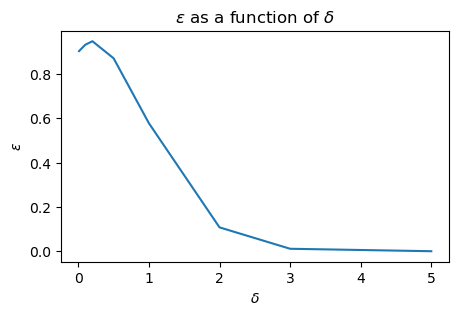

In [18]:
epsilons = []
deltas = [0.01, 0.1, 0.2, 0.5, 1, 2, 3, 5]

for delta in deltas:
    X, _ = worst_case_blob(num_samples=600, delta=delta)
    eps = eps_MST_W(X)
    epsilons.append(eps)
    
fig = plt.figure(figsize=(5,3))

plt.plot(deltas, epsilons)
plt.ylabel("$\epsilon$")
plt.xlabel("$\delta$")
plt.title("$\epsilon$ as a function of $\delta$")
plt.show()

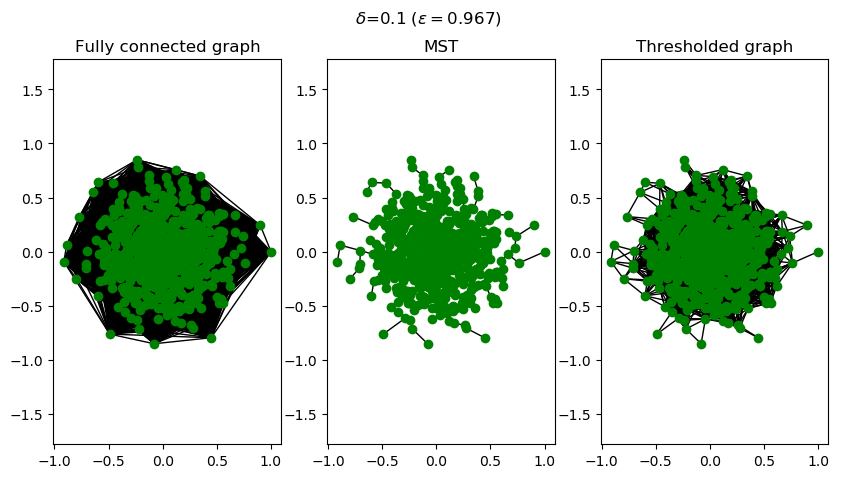

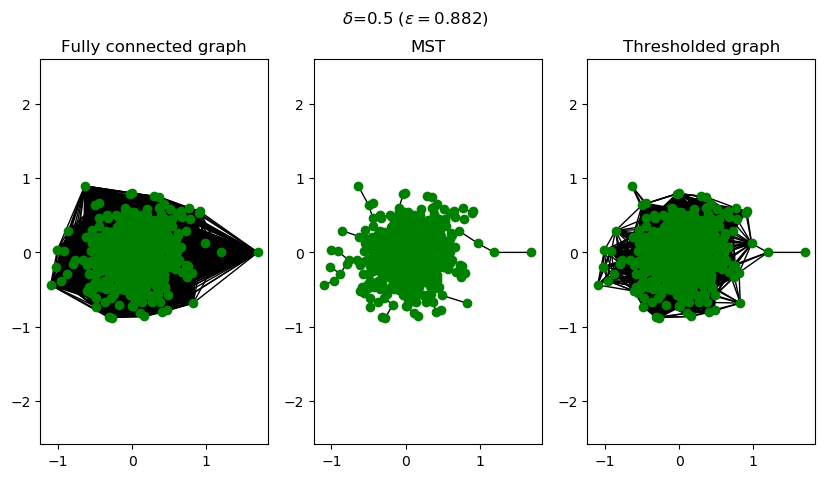

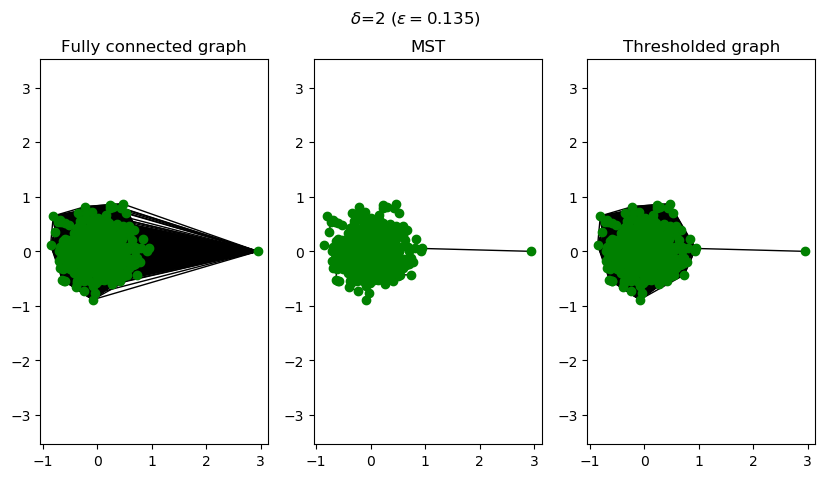

In [19]:
from utils import plot_edges_and_points

for delta in [0.1, 0.5, 2]:
    fig =  plt.figure(figsize=(10,5))

    fig.add_subplot(1,3,1)

    X, _ = worst_case_blob(num_samples=600, delta=delta)
    W = build_similarity_graph(X)
    tree = min_span_tree(-W)
    idx = np.where(tree)
    eps = np.min(W[idx[0], idx[1]])

    plot_edges_and_points(X, Y, W)
    plt.title("Fully connected graph")

    fig.add_subplot(1,3,2)
    plot_edges_and_points(X, Y, W * tree)
    plt.title("MST")

    fig.add_subplot(1,3,3)
    W_thr = build_similarity_graph(X, eps=eps)
    plot_edges_and_points(X, Y, W_thr)
    plt.title("Thresholded graph")

    plt.suptitle("$\delta$={}".format(delta) + " ($\epsilon={}$)".format(np.round(eps, 3)))
    
plt.show()

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

**Answers Q1.3**

To do spectral clustering, we find the minimal cut in the graph (with constrains on the cardinality or the volume of the clusters). Yet, this model cannot be applied if the graph is not connected as there will be no edge to cut between the different separated components. 

**Remark:** We could argue that if the graph is already separated in different components, the clustering is already done, but if the separated components are wrong, there is no way to recover the true clustering.

Connectiveness:

*  **worst_case_blob:** $K-NN$-graphes are always connected (even for $k=1$) whereas $\epsilon$-graphes are not. In fact, as we saw in the previous question, as the distance between the outlier and the blob increases, the maximal thershold ensuring connectiveness tends to 0.
*  **two_moons and point_in_circle:** both $K-NN$-graphes and $\epsilon$-graphes are connected. Yet, too big value of $\epsilon$ and too little values of $k$ break the connectiveness.
*  **blobs:** The $K-NN$ graphes are not connected even for large number of neighbours k=100. With the $K-NN$ method on these examples, $k$ has to be superior to the number of nodes in the cluster. Otherwise, the $k$ nearest neighbours will always belong to the cluster and thus, the graph will remain disconnected. $\epsilon$-graphes are connected for $\epsilon < 0.5$ (but this value depends on the distance between the two clusters).

As a conclusion, to ensure connectiveness, the choice of the graph builder has to take into acount the form of the distribution.

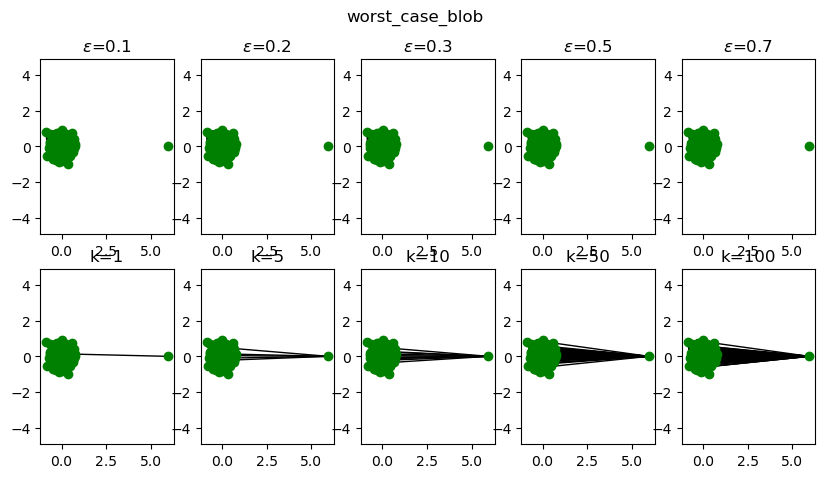

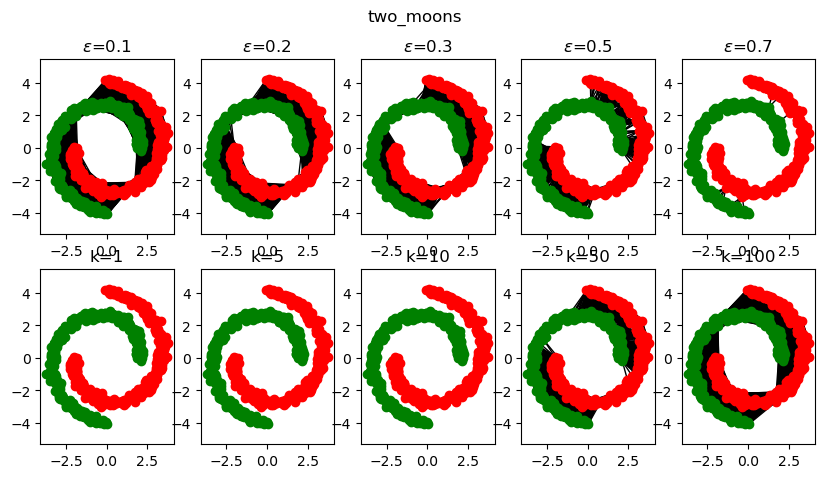

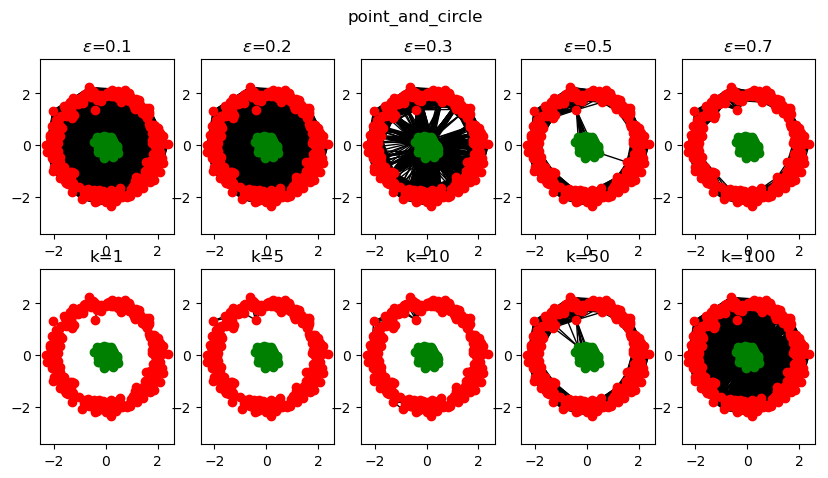

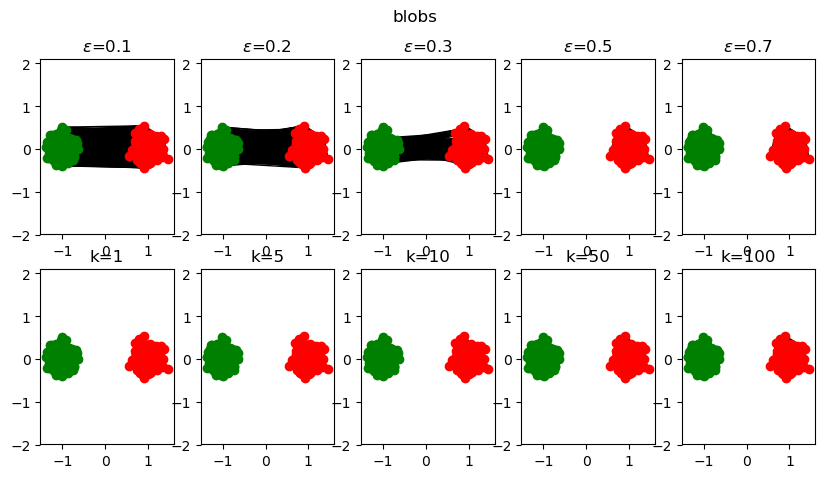

In [20]:
for fn in [worst_case_blob, two_moons, point_and_circle, blobs]:
    X, Y = fn(num_samples=600)
    fig =  plt.figure(figsize=(10,5))

    idx = 1
    # Threshold
    for eps in [0.1, 0.2, 0.3, 0.5, 0.7]:

        fig.add_subplot(2,5,idx)
        idx += 1

        W_thr = build_similarity_graph(X, eps=eps)
        plot_edges_and_points(X, Y, W_thr)
        plt.title("$\epsilon$={}".format(eps))

    # K-NN
    for k in [1, 5, 10, 50, 100]:

        fig.add_subplot(2,5,idx)
        idx += 1

        W_knn = build_similarity_graph(X, k=k)
        plot_edges_and_points(X, Y, W_knn)
        plt.title("k={}".format(k))

    plt.suptitle(str(fn.__name__))
        
plt.show()

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

**Answers Q2.1**


From the previous method, we built the graph using $\epsilon$-graph threshold with $\epsilon$ determined by the method in Q1.

The plot of the $10$ first eigenvalues shows that there is a huge gap between the 2nd and the 3rd eigenvalue. This indicates that there is no more usefull information for the spectral clustering after the 3rd eigenvalue (included). The display of the associated eigenvectors leads to the same conclusion:

*  The first eigenvector is the constant vector equals to 1. Thus, it does not provide any further information on the clustering. 
*  On the second eigenvectors, there is a clear distinction between the two clusters, whereas we cannot visually identify them on the other eigenvectors.  

Thus, to extract the clustering, we do a **K-Means classification** for a given number of classes (here 2), on the **second eigenvector**.

The results show that this method performs well but that performing a K-Means classification directly on the input data achieves the same performance

In [21]:
blobs?
X, Y = blobs(num_samples=600)
plot_clusters(X, Y)

Signature: blobs(num_samples, n_blobs=2, blob_var=0.15, surplus=0)
Docstring:
Creates N gaussian blobs evenly spaced across a circle.

:param num_samples: number of samples to create in the dataset
:param n_blobs:      how many separate blobs to create
:param blob_var:    gaussian variance of each blob
:param surplus:     number of extra samples added to first blob to create unbalanced classes
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      c:\users\cgris\onedrive\documents\enpc\4a 2022-2023\s2\graph in ml\spectral_clustering\generate_data.py
Type:      function


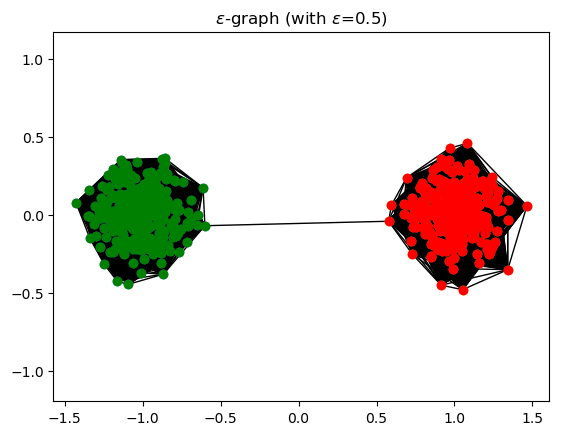

In [22]:
# Epsilon-graph based on the MST

W = build_similarity_graph(X)
tree = min_span_tree(-W)
idx = np.where(tree)
eps = np.min(W[idx[0], idx[1]])

W_thr = build_similarity_graph(X, eps=eps)
plot_edges_and_points(X, Y, W_thr)
plt.title("$\epsilon$-graph (with $\epsilon$={})".format(np.round(eps, 2)))
plt.show()

#### Display eigenvalues and eigenvectors

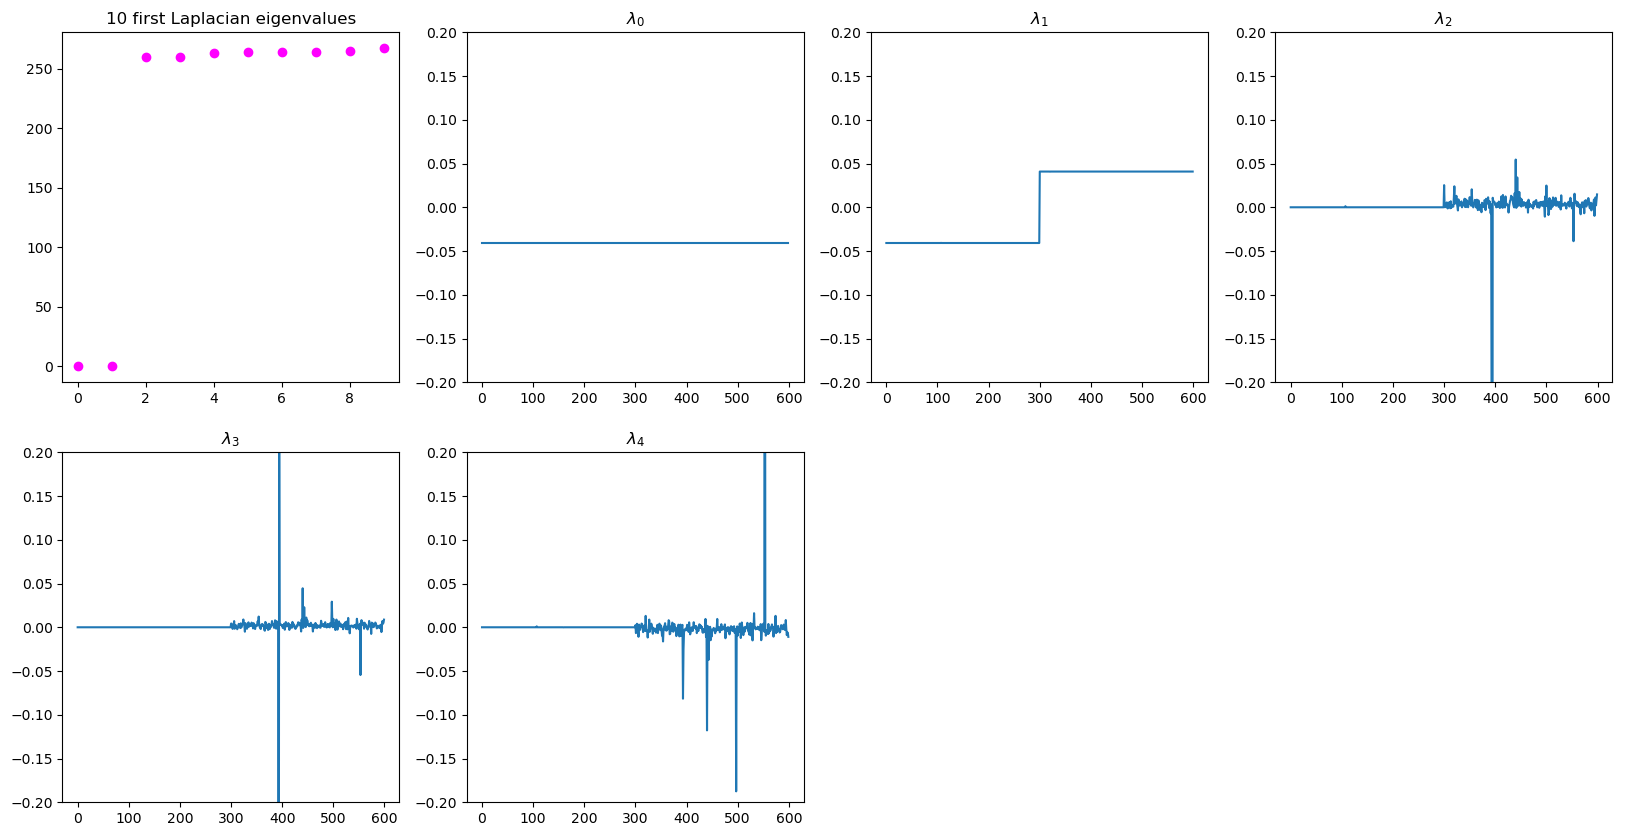

In [23]:
# Compute the Laplacian
L = build_laplacian(W_thr)

# Compute sorted eigenvalues/eigenvectors
eig_values, eig_vectors = scipy.linalg.eig(L)
sort_idx = np.argsort(eig_values)
U = np.real(eig_vectors[:, sort_idx])
E = np.real(eig_values[sort_idx])
fig = plt.figure(figsize=(20,10))

# Eigenvalues
n = 10
fig.add_subplot(2,4,1)
plt.scatter(range(n), E[:n], c="magenta")
plt.title("10 first Laplacian eigenvalues")

# Eigenvectors
for idx in range(5):
    fig.add_subplot(2,4,idx+2)
    plt.plot(U[:, idx])
    plt.ylim(-0.2,0.2)
    plt.title("$\lambda_{}$".format(idx))
plt.show()  

#### Clustering

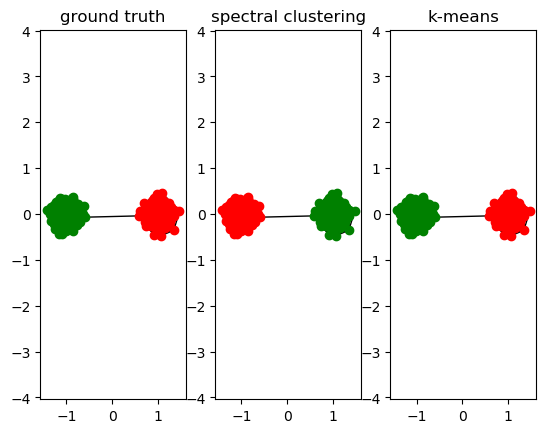

In [24]:
# Spectral clustering
num_classes = 2
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, W, Y_rec, KMeans(num_classes).fit_predict(X))

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

**Answers Q2.2**


From the previous question, we compute the graph with $K-NN$ with k=5 which results in an unconnected graph.

The plot of the $10$ first eigenvalues shows that there is also gap between the 2nd and the 3rd eigenvalue. Yet, the gap is way less important than in the previous question. And indeed, we see that the other eigenvectors contain information on the clustering as well. We can also note that the first eigenvector is no more constant equals to 1.

Even though there remain information in the other eigenvectors, we do the **K-Means classification** on the **first and second eigenvectors**.

As in the previous question, this method performs well but like the global K-Means classification.

In [25]:
X, Y = blobs(num_samples=600)
plot_clusters(X, Y)

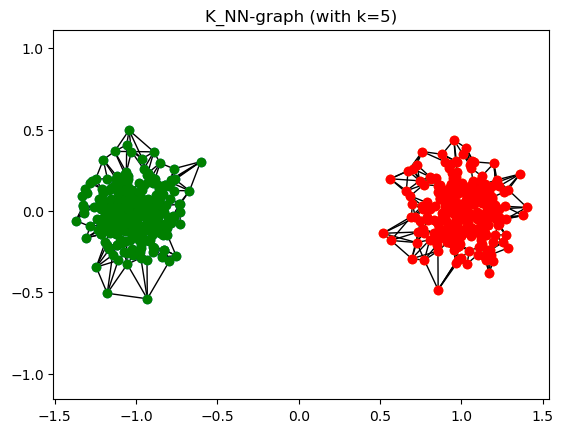

In [26]:
# Knn graph
k = 5
W_knn = build_similarity_graph(X, k=k)
plot_edges_and_points(X, Y, W_knn)
plt.title("K_NN-graph (with k={})".format(k))
plt.show()

In [27]:
# Compute the Laplacian
L = build_laplacian(W_knn)

# Compute sorted eigenvalues/eigenvectors
eig_values, eig_vectors = scipy.linalg.eig(L)
sort_idx = np.argsort(eig_values)
U = np.real(eig_vectors[:, sort_idx])
E = np.real(eig_values[sort_idx])

#### Display eigenvalues and eigenvectors

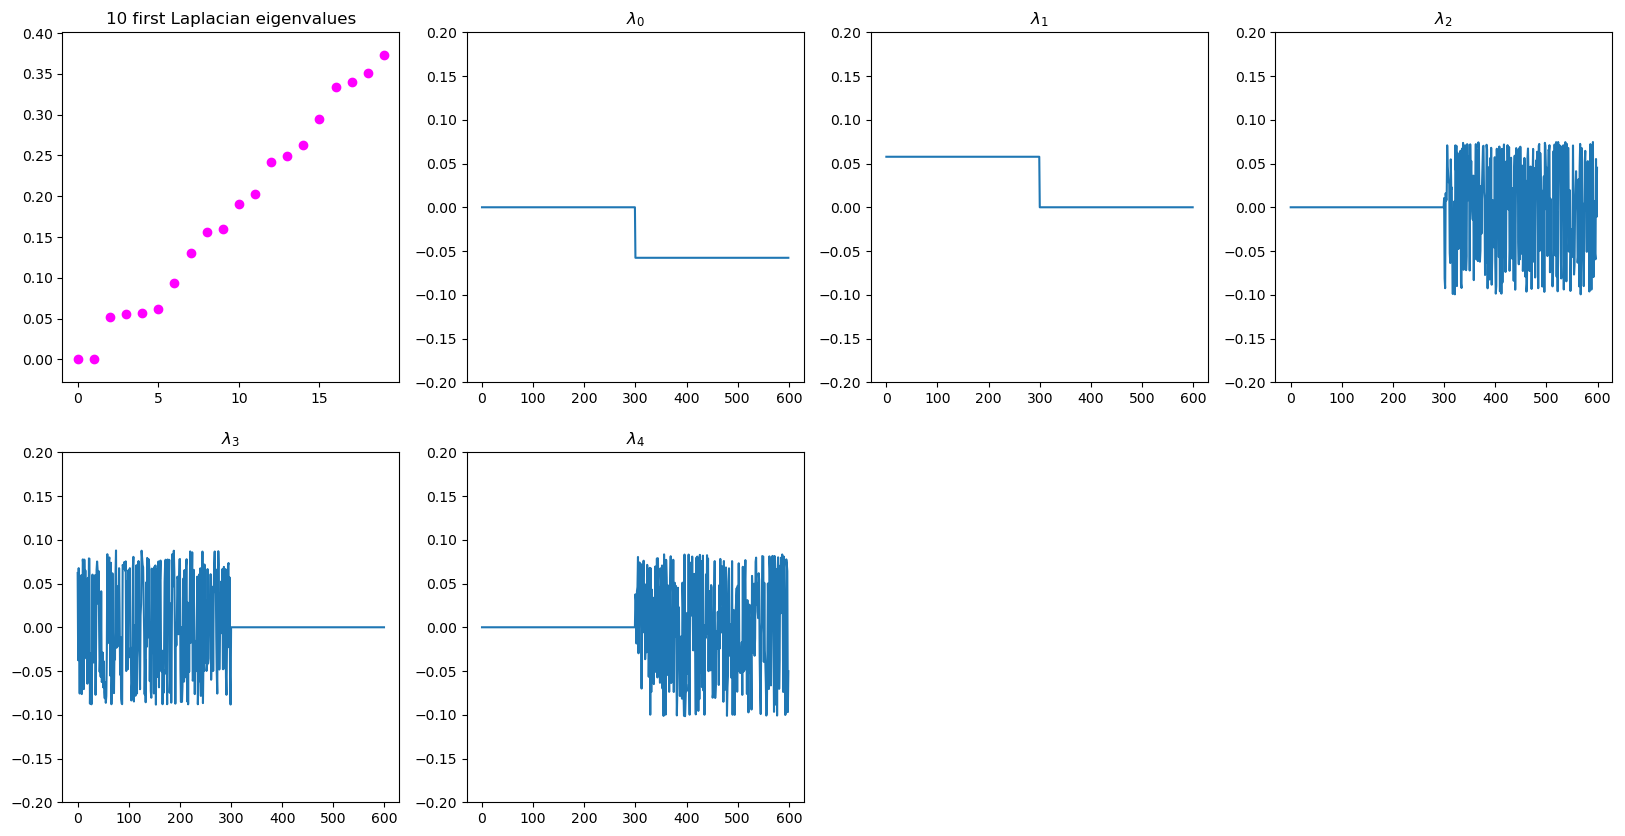

In [28]:
fig = plt.figure(figsize=(20,10))

# Eigenvalues
n = 20
fig.add_subplot(2,4,1)
plt.scatter(range(n), E[:n], c="magenta")
plt.title("10 first Laplacian eigenvalues")

# Eigenvectors
for idx in range(5):
    fig.add_subplot(2,4,idx+2)
    plt.plot(U[:, idx])
    plt.ylim(-0.2,0.2)
    plt.title("$\lambda_{}$".format(idx))
plt.show()  

#### Clustering

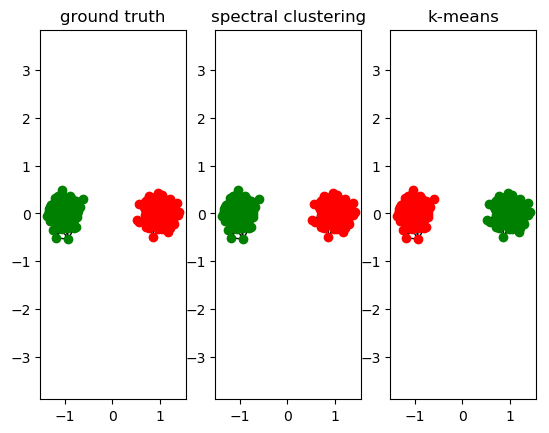

In [29]:
# Spectral clustering
num_classes = 2
Y_rec = spectral_clustering(L, chosen_eig_indices=[0,1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

**Answers Q2.3**

We need a heuristic that identifies the eigenvalues gap. Once the gap is identified, we use the eigenvectors associated to the eigenvalues before the gap to construct the clustering by applying K-Means. To do so, we look for the maximal gap inside the $n_{classes}+1$ first eigenvalues. A gap is defined as $$g_i = \lambda_{i+1} - \lambda_i$$

**Remark:** we could have remove the first eigenvectors but we saw in the previous example that it can contain information and if it is the constant vector to 1, it will not hamper spectral clustering.

When the variance increases, the spectral clustering fails to distinguish the clusters as they are interwined. As as result, the gap between the eigenvalues gets smaller and is no more detected by the method. The K-Means classification still succeed in finding approximate clusters even though the clustering is not as good as the results with lower variance. 

In [32]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.25)
plot_clusters(X, Y)

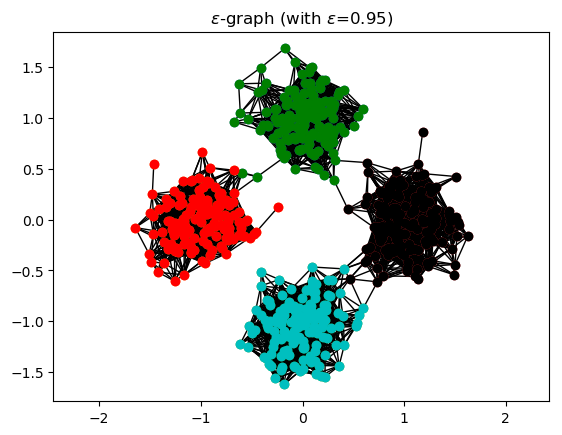

In [33]:
# Epsilon-graph based on the MST

W = build_similarity_graph(X)
tree = min_span_tree(-W)
idx = np.where(tree)
eps = np.min(W[idx[0], idx[1]])

W_thr = build_similarity_graph(X, eps=eps)
plot_edges_and_points(X, Y, W_thr)
plt.title("$\epsilon$-graph (with $\epsilon$={})".format(np.round(eps, 2)))
plt.show()

#### Display eigenvalues and eigenvectors

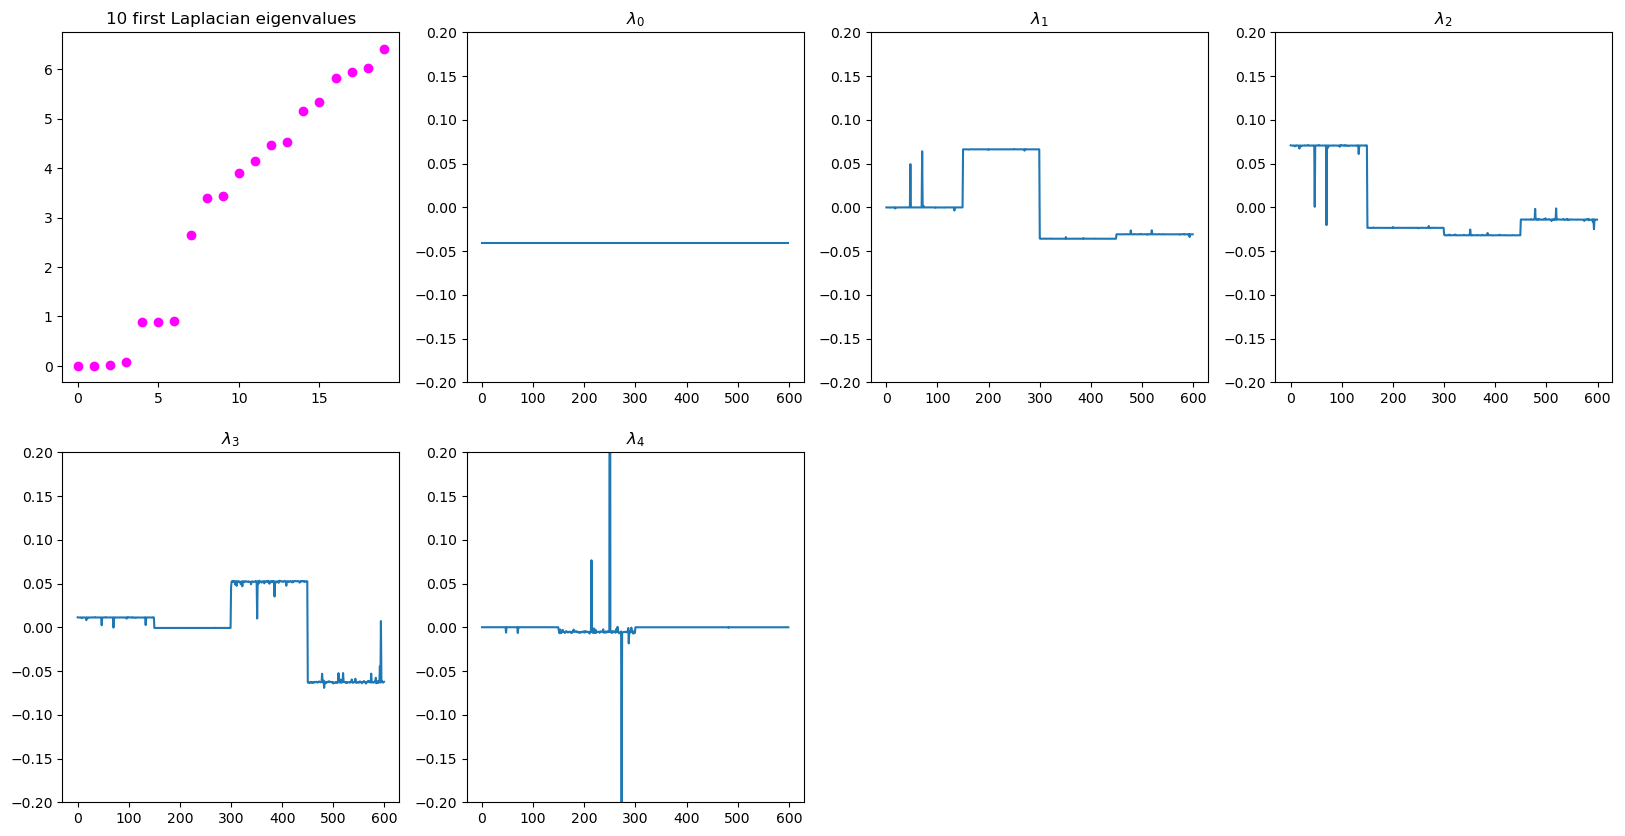

In [34]:
# Compute the Laplacian
L = build_laplacian(W_thr)

# Compute sorted eigenvalues/eigenvectors
eig_values, eig_vectors = scipy.linalg.eig(L)
sort_idx = np.argsort(eig_values)
U = np.real(eig_vectors[:, sort_idx])
E = np.real(eig_values[sort_idx])

fig = plt.figure(figsize=(20,10))

# Eigenvalues
n = 20
fig.add_subplot(2,4,1)
plt.scatter(range(n), E[:n], c="magenta")
plt.title("10 first Laplacian eigenvalues")

# Eigenvectors
for idx in range(5):
    fig.add_subplot(2,4,idx+2)
    plt.plot(U[:, idx])
    plt.ylim(-0.2,0.2)
    plt.title("$\lambda_{}$".format(idx))
plt.show()  

#### Clustering

Variance=0.15


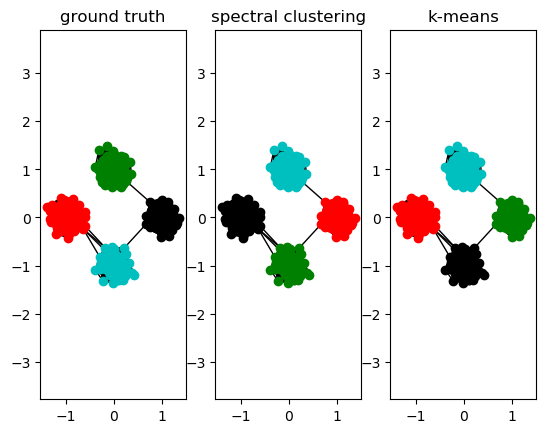

Variance=0.25


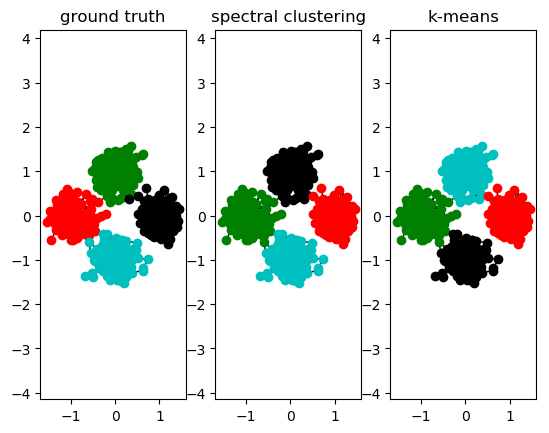

Variance=0.35


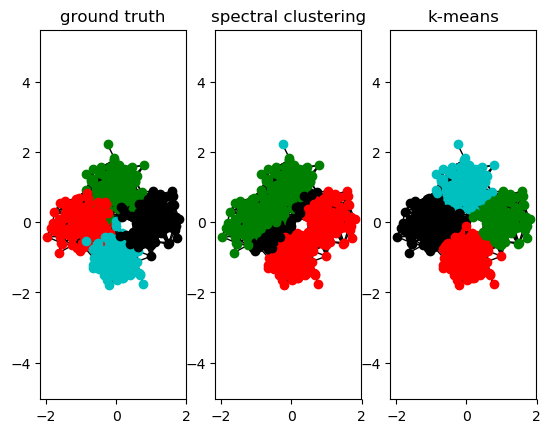

Variance=0.5


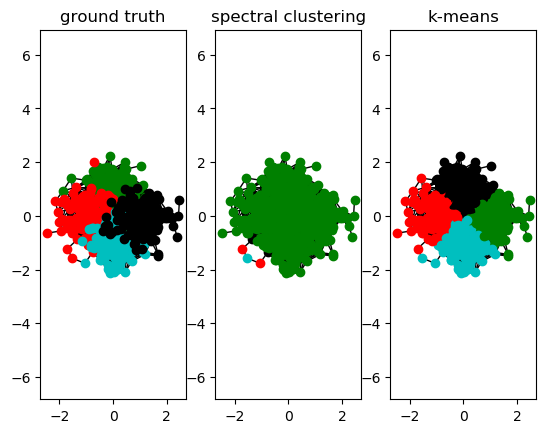

In [ ]:
# Example
for var in [0.15, 0.25, 0.35, 0.5]:

    print("Variance={}".format(var))
    X, Y = blobs(num_samples=600, n_blobs=4, blob_var=var)
    
    eps = eps_MST_W(X)
    W = build_similarity_graph(X, eps=eps)
    L = build_laplacian(W)

    num_classes = 4
    Y_rec = spectral_clustering(L, num_classes=num_classes)

    # Plot results, comparing to KMeans
    plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

**Answers Q2.4**

To built the clustering, we only use **k-means** on the set of chosen eigenvectors (with k the number of classes).

**Thresholding** is less expensive than k-means but it could be hard to find a threshold value that provides good results for any spectral clustering cases.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

**Answers Q2.5**

The spectral clustering performs better than the global K-Means clustering.
In fact, the spectral clustering succeeds in retrieving exactly the clusters whereas the global kmeans fails (by doing something like a linear classification).

This can be attributed to the fact that global K-Means clustering groups points that are similar in terms of their location in the plane, i.e., points that are "close" in terms of Euclidean distance. However, in the two_moons distribution, points belonging to the same moon can be far apart in terms of Euclidean distance (like the extremums of the moon), leading to the failure of the global K-Means clustering. On the other hand, spectral clustering takes into account the connectivity of the points. For the two_moons distribution, the graph is composed of two highly connected components, with few links connecting the two components. Hence, it is easier for spectral clustering, which is based on this graph, to accurately cluster the two moons.

In [34]:
two_moons?
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

Signature: two_moons(num_samples, moon_radius=2.0, moon_var=0.02)
Docstring:
Creates two intertwined moons

:param num_samples: number of samples to create in the dataset
:param moon_radius: radius of the moons
:param moon_var:    variance of the moons
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      c:\users\cgris\onedrive\documents\enpc\4a 2022-2023\s2\graph in ml\spectral_clustering\generate_data.py
Type:      function


In [35]:
def eps_MST_W(X):
    n_samples = X.shape[0]
    W = build_similarity_graph(X)

    # Compute the MST on the Euclidian distance matrix
    dist = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            dist[i,j] = np.linalg.norm(X[i] - X[j])
    tree = min_span_tree(dist)

    # Get the threshold epsilon
    idx = np.where(tree)
    eps = np.min(W[idx[0], idx[1]])
    return eps

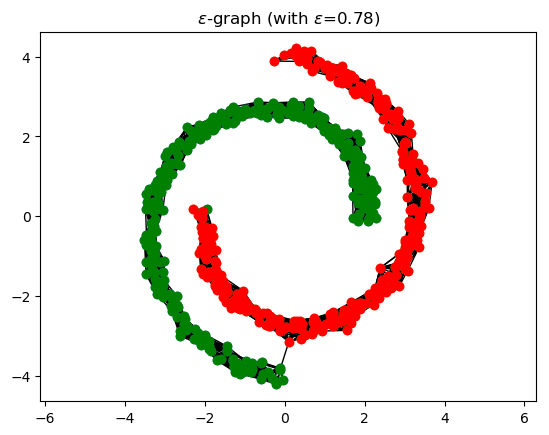

In [36]:
# Epsilon-graph based on the MST
eps = eps_MST_W(X)

W_thr = build_similarity_graph(X, eps=eps)
plot_edges_and_points(X, Y, W_thr)
plt.title("$\epsilon$-graph (with $\epsilon$={})".format(np.round(eps, 2)))
plt.show()

#### Display eigenvalues and eigenvectors

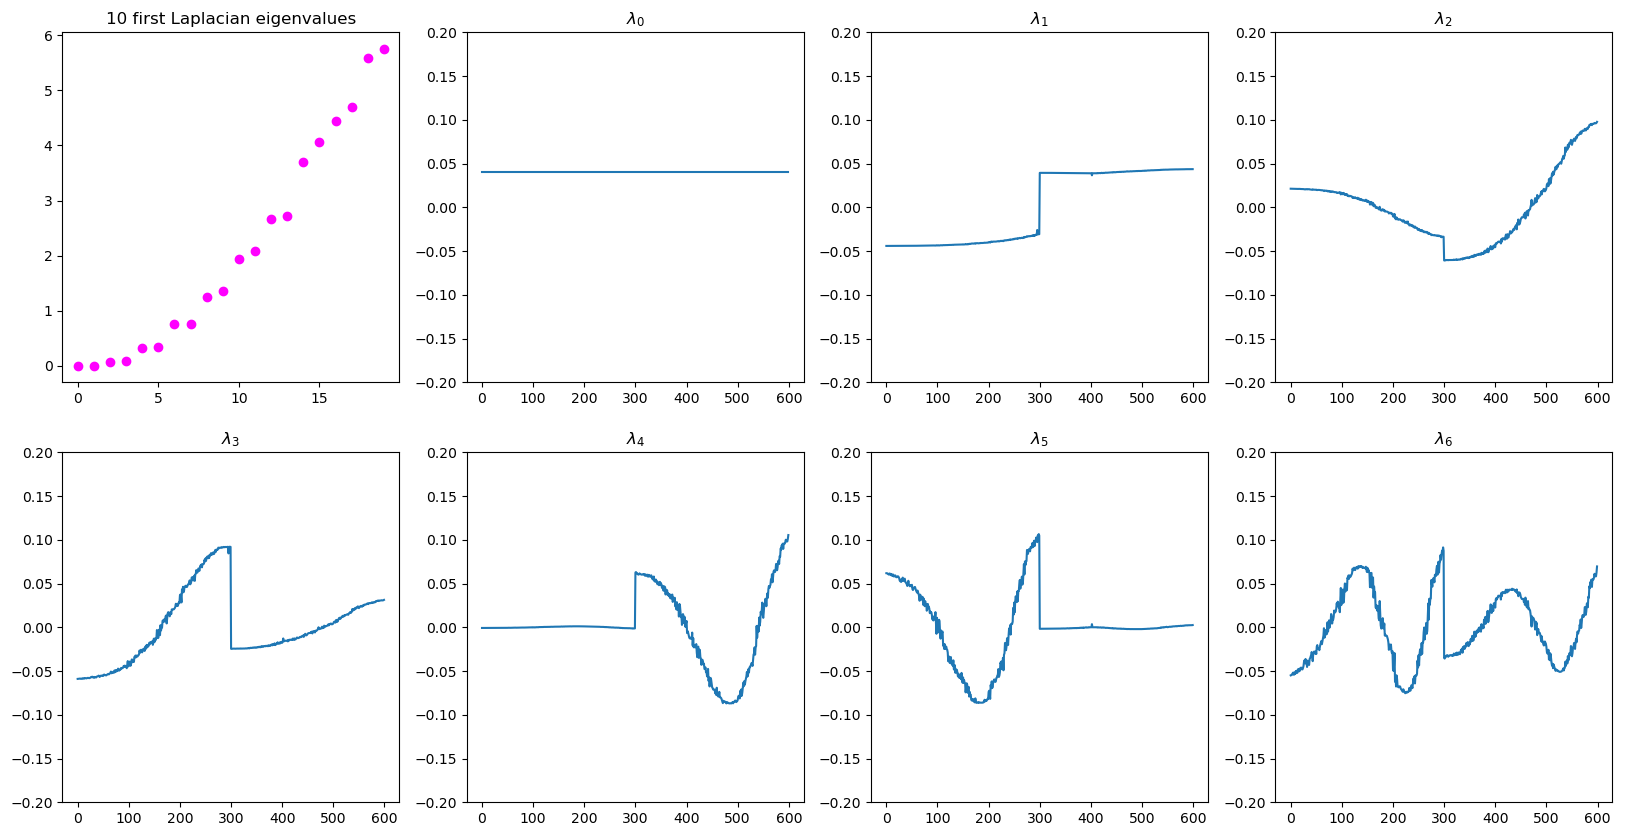

In [37]:
# Compute the Laplacian
L = build_laplacian(W_thr)

# Compute sorted eigenvalues/eigenvectors
eig_values, eig_vectors = scipy.linalg.eig(L)
sort_idx = np.argsort(eig_values)
U = np.real(eig_vectors[:, sort_idx])
E = np.real(eig_values[sort_idx])

fig = plt.figure(figsize=(20,10))

# Eigenvalues
n = 20
fig.add_subplot(2,4,1)
plt.scatter(range(n), E[:n], c="magenta")
plt.title("10 first Laplacian eigenvalues")

# Eigenvectors
for idx in range(7):
    fig.add_subplot(2, 4, idx+2)
    plt.plot(U[:, idx])
    plt.ylim(-0.2,0.2)
    plt.title("$\lambda_{}$".format(idx))
plt.show()  

#### Clustering

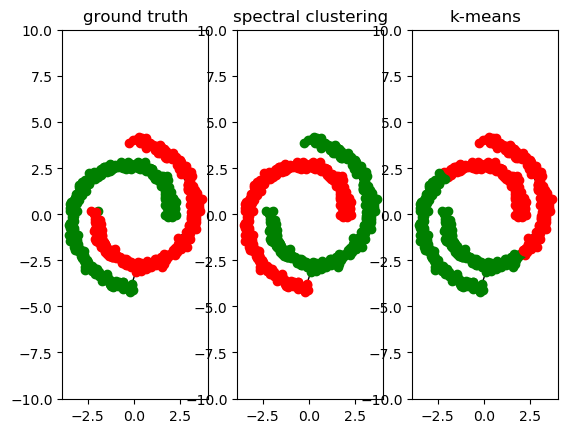

In [38]:
# Example
num_classes = 2
Y_rec = spectral_clustering(L, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

**Answers Q2.6**

Like in the previous example, it is not possible to only rely on Euclidian distance to identify the cluster. As a result, global k-means clustering does not work.

For the same graph construction, using the normal Laplacian leads to a successful clustering of the distributions. Whereas using the random-walk regularized Laplacian does not produce correct results. This can be explained by looking at the difference in the eigenvalues of the two Laplacians. The random-walk regularized Laplacian normalizes the Laplacian, which in turn normalizes the eigenvalues and the gap. As a result, the gap becomes smaller, making the method for identifying the eigenvalue gap ineffective. The gap is $\approx 0.05$ for the regularized laplacian and $\approx 1.5$ for the normal Laplacian.

In [27]:
point_and_circle?
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

Signature: point_and_circle(num_samples, radius=2.0, sigma=0.15)
Docstring:
Creates point and circle

:param num_samples: number of samples to create in the dataset
:param sigma:       variance
:param radius:      radius of the circle
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment in {0, ..., c-1}
File:      c:\users\cgris\onedrive\documents\enpc\4a 2022-2023\s2\graph in ml\spectral_clustering\generate_data.py
Type:      function


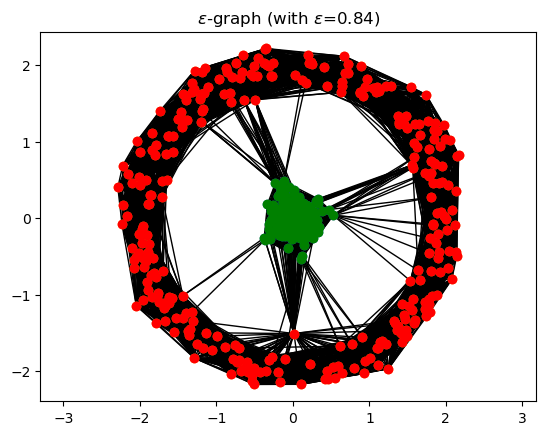

In [28]:
# Epsilon-graph based on the MST
W_thr = build_similarity_graph(X, eps=0.4)
plot_edges_and_points(X, Y, W_thr)
plt.title("$\epsilon$-graph (with $\epsilon$={})".format(np.round(eps, 2)))
plt.show()

#### Display eigenvalues and eigenvectors

##### Unormalized Laplacian

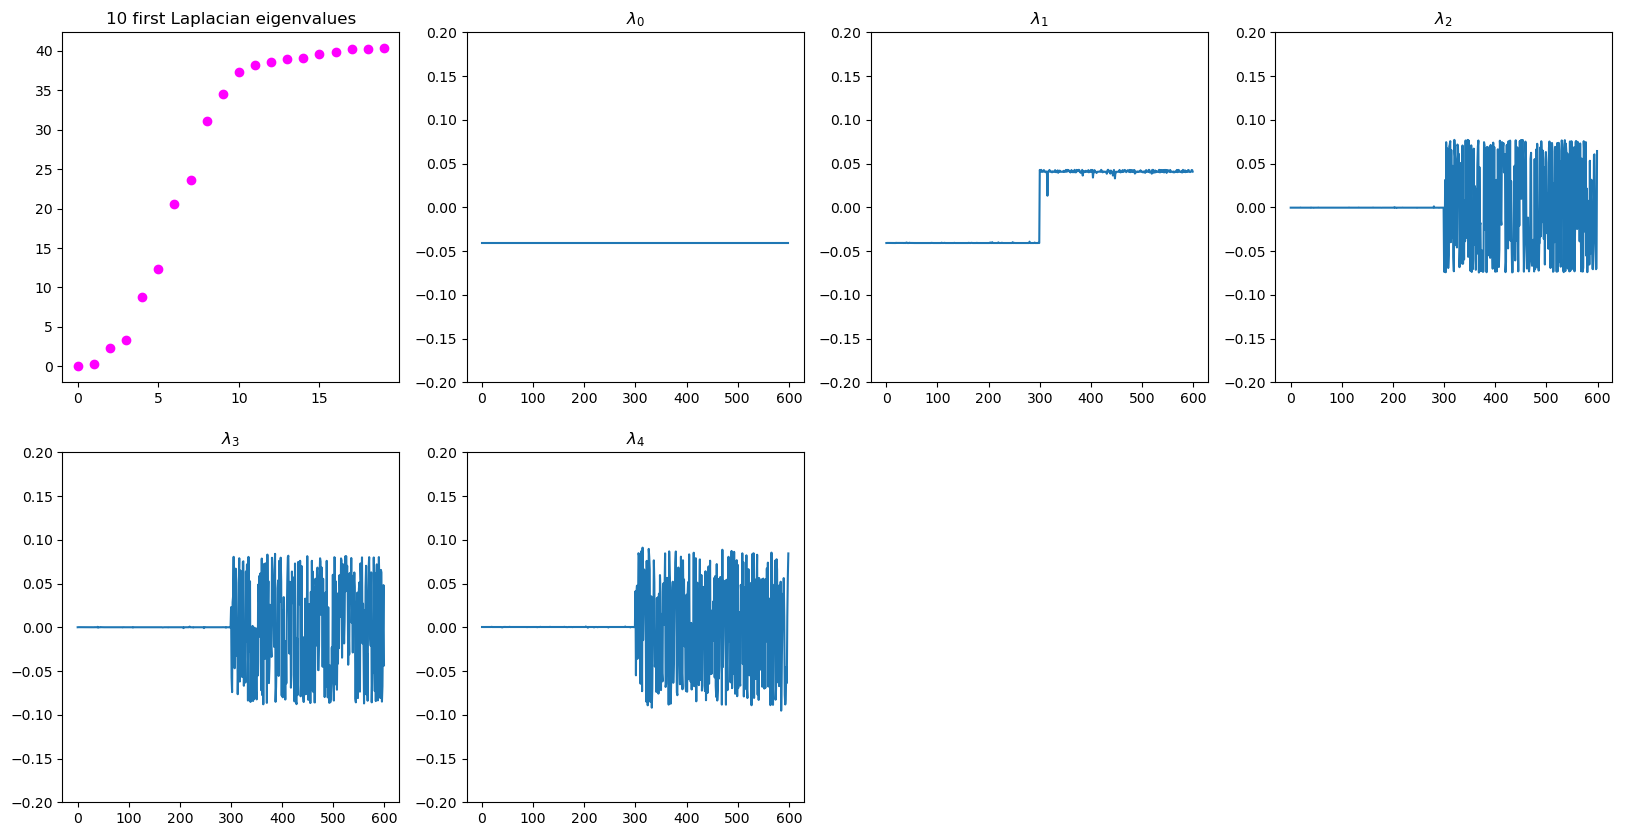

In [29]:
# Compute the Laplacian
L = build_laplacian(W_thr)

# Compute sorted eigenvalues/eigenvectors
eig_values, eig_vectors = scipy.linalg.eig(L)
sort_idx = np.argsort(eig_values)
U = np.real(eig_vectors[:, sort_idx])
E = np.real(eig_values[sort_idx])

fig = plt.figure(figsize=(20,10))

# Eigenvalues
n = 20
fig.add_subplot(2,4,1)
plt.scatter(range(n), E[:n], c="magenta")
plt.title("10 first Laplacian eigenvalues")

# Eigenvectors
for idx in range(5):
    fig.add_subplot(2, 4, idx+2)
    plt.plot(U[:, idx])
    plt.ylim(-0.2,0.2)
    plt.title("$\lambda_{}$".format(idx))
plt.show()  

##### Random-walked Laplacian

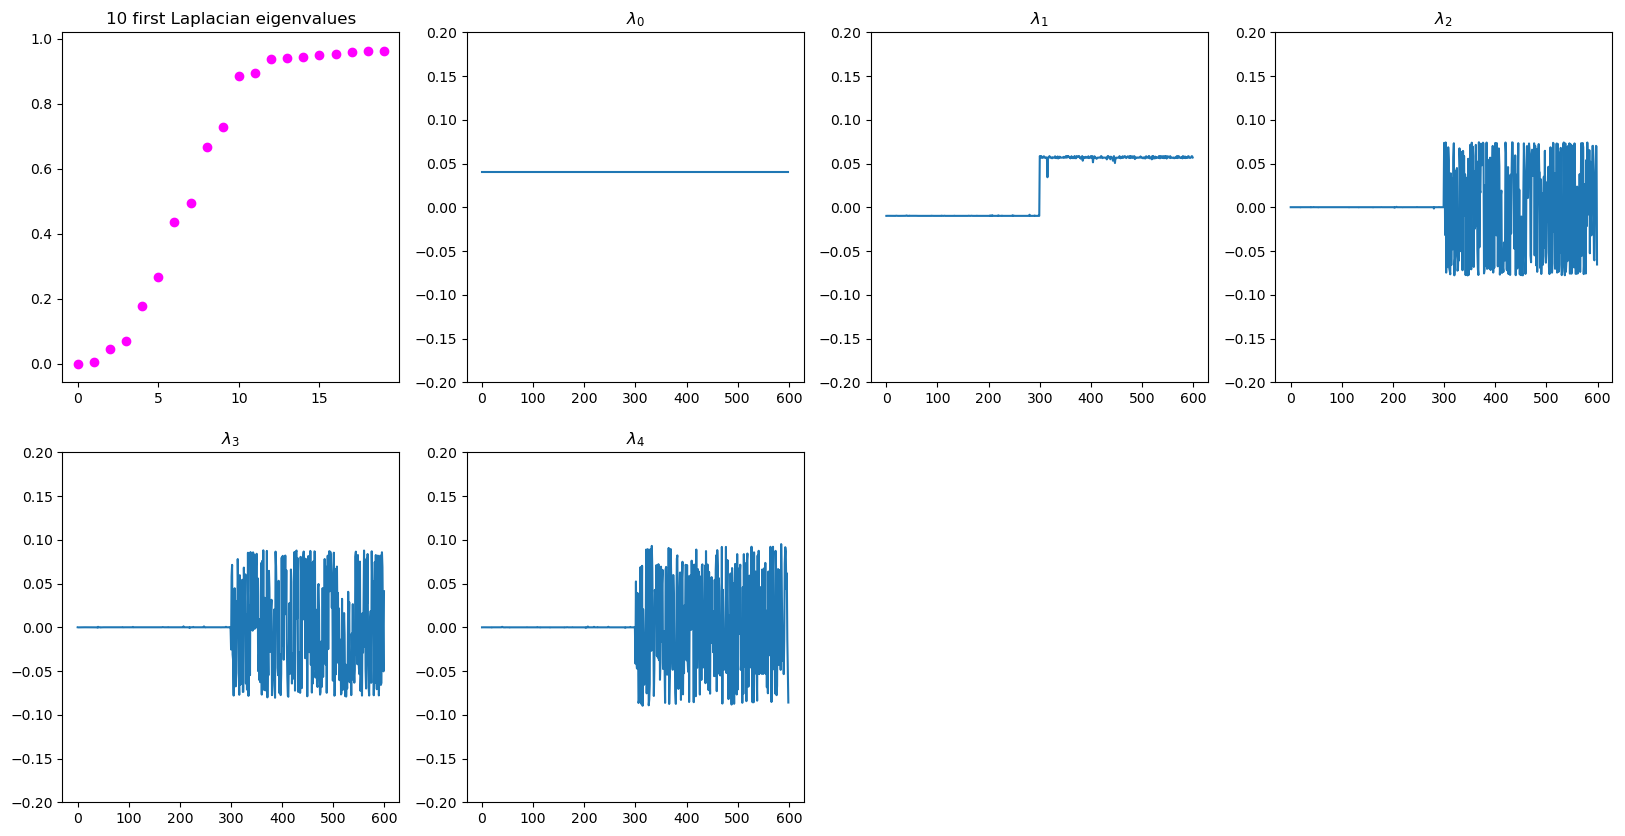

In [30]:
# Compute the Laplacian
L = build_laplacian(W_thr, laplacian_normalization='rw')

# Compute sorted eigenvalues/eigenvectors
eig_values, eig_vectors = scipy.linalg.eig(L)
sort_idx = np.argsort(eig_values)
U = np.real(eig_vectors[:, sort_idx])
E = np.real(eig_values[sort_idx])

fig = plt.figure(figsize=(20,10))

# Eigenvalues
n = 20
fig.add_subplot(2,4,1)
plt.scatter(range(n), E[:n], c="magenta")
plt.title("10 first Laplacian eigenvalues")

# Eigenvectors
for idx in range(5):
    fig.add_subplot(2, 4, idx+2)
    plt.plot(U[:, idx])
    plt.ylim(-0.2,0.2)
    plt.title("$\lambda_{}$".format(idx))
plt.show()  

#### Clustering

Clustering using unormalized Laplacian


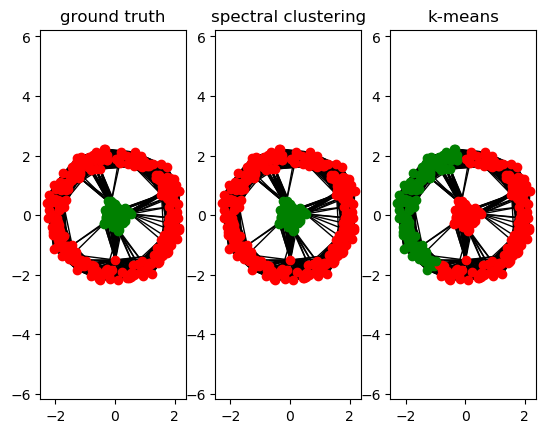

Clustering using random-walk regularized Laplacian


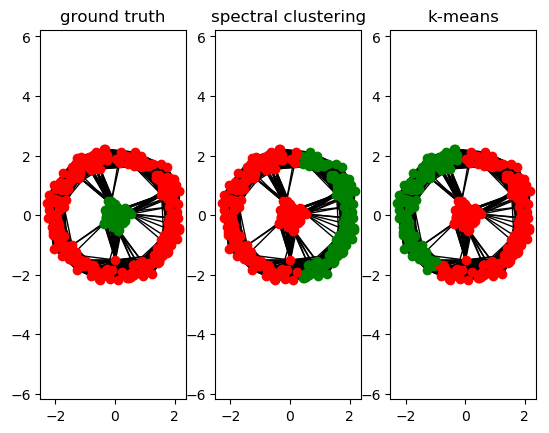

In [31]:
# Example
num_classes = 2

L = build_laplacian(W_thr)
L_rw = build_laplacian(W_thr, laplacian_normalization='rw')

Y_rec = spectral_clustering(L, num_classes=num_classes)
Y_rec_rw = spectral_clustering(L_rw, num_classes=num_classes)

# Plot results, comparing to KMeans
print("Clustering using unormalized Laplacian")
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

print("Clustering using random-walk regularized Laplacian")
plot_clustering_result(X, Y, L_rw, Y_rec_rw, KMeans(num_classes).fit_predict(X))

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

**Answers Q2.7**

The results of spectral clustering varies a lot depending on how the graph is constructed, both for $\epsilon$ and KNN graphes. This sensitivity seems to be even more pronounced for complex distributions. In fact, the clustering is optimal for the worst_case_blob distribution and good for blobs, for all the values of the graph construction parameters $k$ or $\epsilon$. However, for the point_in_circle distribution, the quality of the results is much more dependent on the value of these parameters, particularly for $\epsilon$-graphs. The sensitivity is at its highest for the two_moons distribution, which is the most complicated distribution. The results are goodd for large value of $\epsilon$ i.e. highly connected graph and for a very small range of parameters $k$.

**Remark:** Using the symmetric regularized Laplacian appears to provide more robust results, with stable outcomes over wider ranges of parameter values both on $k$ and $\epsilon$.


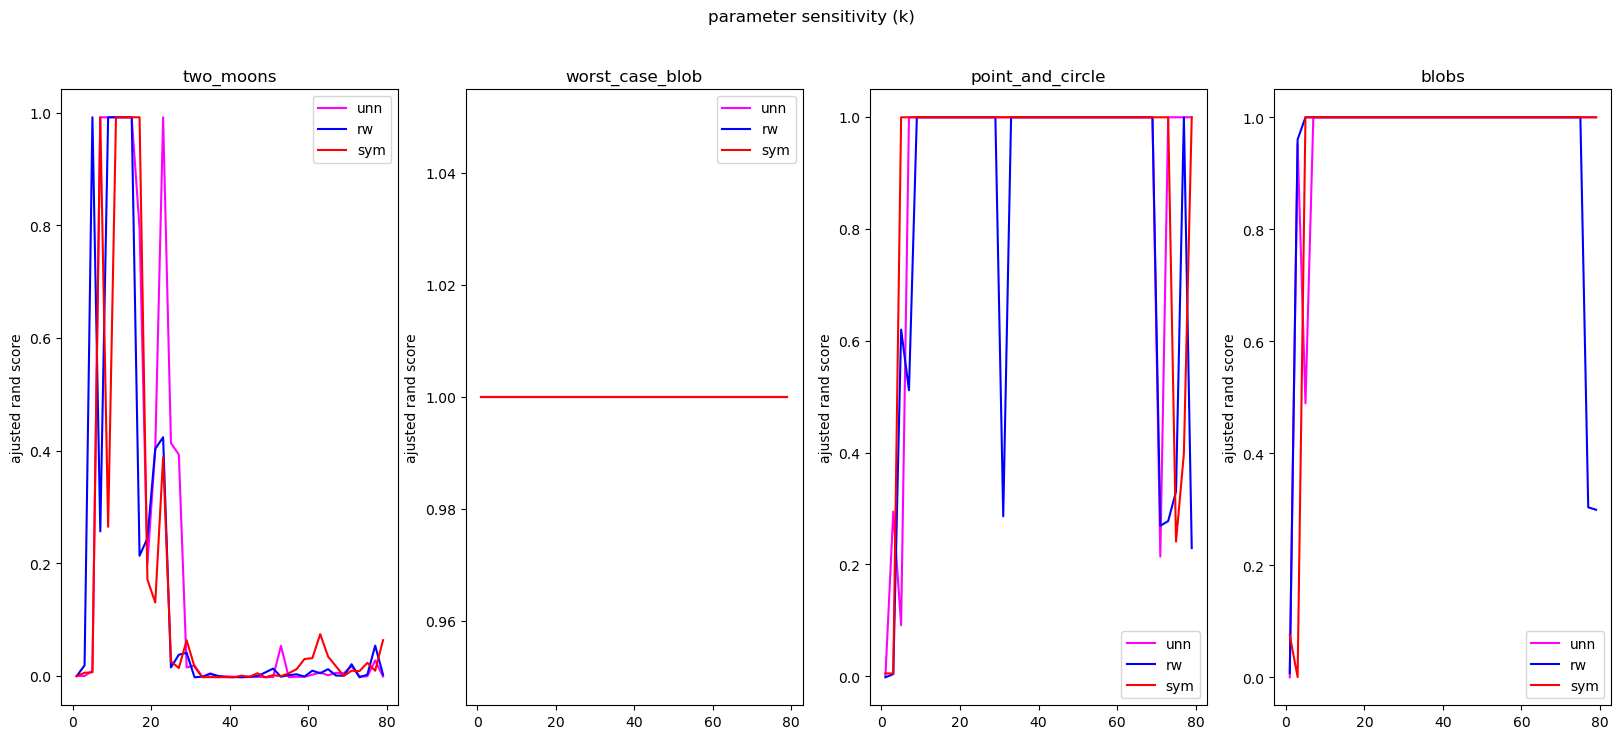

In [144]:
parameter_sensitivity("k")

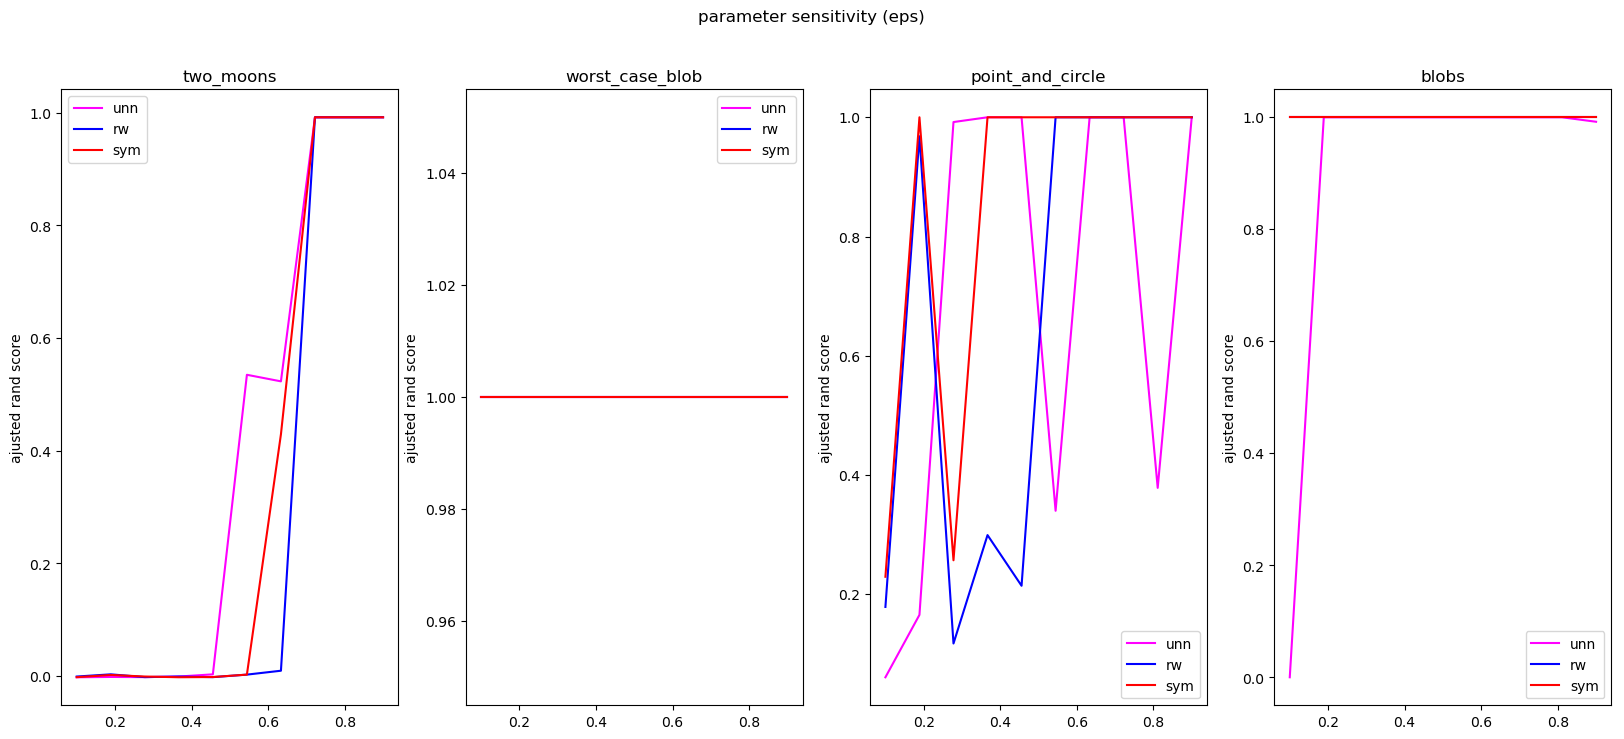

In [145]:
parameter_sensitivity("eps")

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

**Answer Q2.8**

As we have seen before, global K-means clustering failes as it only take into account the Euclidian distance between the points. Thus, using clustering evaluation based on the same Euclidian distance, like barycenter distance would not be a good idea either.

*  Methods that take into account the shape of the distribution should be favored. 
*  Methods evaluating the similarity between points belonging to the same cluster and disymilarity between points belonging to different clusters should also be favored. The David-Bouldin index satifies is based on this idea. 

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

**Answers Q3.1**

**Graph and pre-processing**

We consider the following graph:

*  Each pixel is a node
*  The weight $w_{ij}$ between the nodes $i$ and $j$ is the exponential distance $d(x_i, x_j)$ (defined above) between the RGB intensities of the pixels $x_i$ and $x_j$.

The RGB intensity $x_i$ is normalised using the following formula:
$$
x_i'=\frac{x_i-min(X)}{max(X) - min(X)}
$$

so that $x_i' \in [0,1]^3$.

To reduce the number of edges in the graph, we apply a KNN algorithm, where the number of neighbors $k$ is optimized for each image ($k=20$ for the 'four_elements' image and $k=180$ for the 'fruit_salad' image).

The number of clusters for the image segmentation is manually defined and passed as an input of the image_segmentation function (5 clusters for the 'four_elements' image and 4 clusters for the 'fruit_salad' image).

Based on the previous questions, the symmetric regularized Laplacian seems to perform better on the different distributions. Thus, we perform spectral clustering on this Laplacian, using the automatic eigenvector selector defined in a previous question.

**Impacts on the results**

*   The results for the optimized parameters $k$ of the KNN algorithm are quite good. 
*   However, to get robust results, the number of neighbords for the Knn graph must be high for the 'fruit_salad' image and not far from $\approx 15$ for the 'four_elements' image.
*   On the 'fruit_salad' image, there are reflections in the orange area which misleads the algorithm (the reflection on the orange part is in the light green cluster).
*  The results of the 'fruit_salad' segmentation remain unchanged regardless of the type of Laplacian used (unnormalized, random-walk, or symmetric) for the same KNN graph. However, the spectral clustering performs badly on the 'four_element' image when using the unormalized of the random-walk Laplacians.
*  The failure cases appear when the number of neighbords $k$ used to build the graph is too small. 

##### Good results

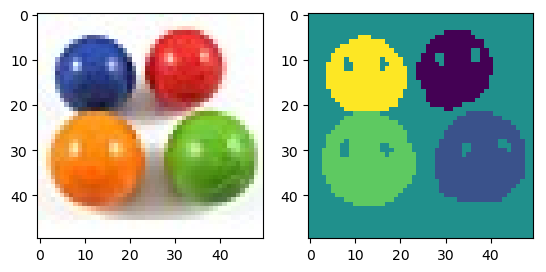

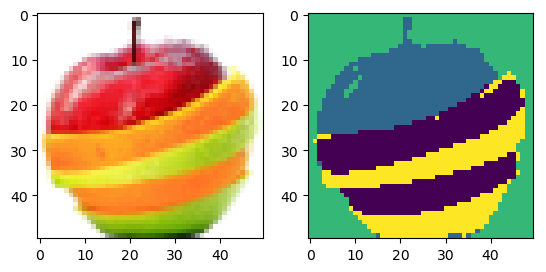

In [15]:
image_segmentation(input_img='four_elements.bmp', k=20, num_classes=5, laplacian_normalization='sym')
image_segmentation(input_img='fruit_salad.bmp', k=180, num_classes=4, laplacian_normalization='sym')

##### Using different Laplacians

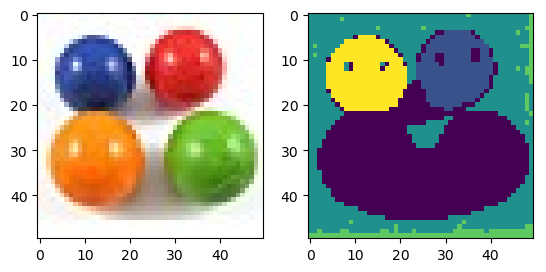

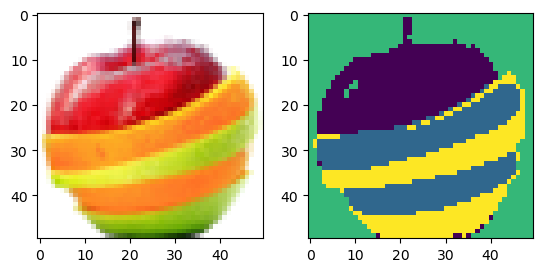

In [19]:
image_segmentation(input_img='four_elements.bmp', k=20, num_classes=5, laplacian_normalization='unn')
image_segmentation(input_img='fruit_salad.bmp', k=180, num_classes=4, laplacian_normalization='unn')

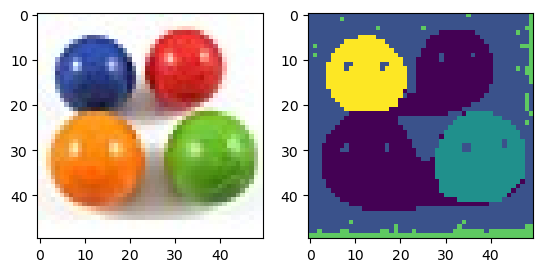

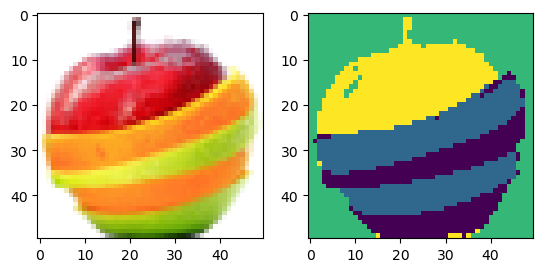

In [20]:
image_segmentation(input_img='four_elements.bmp', k=20, num_classes=5, laplacian_normalization='rw')
image_segmentation(input_img='fruit_salad.bmp', k=180, num_classes=4, laplacian_normalization='rw')

##### Failure cases

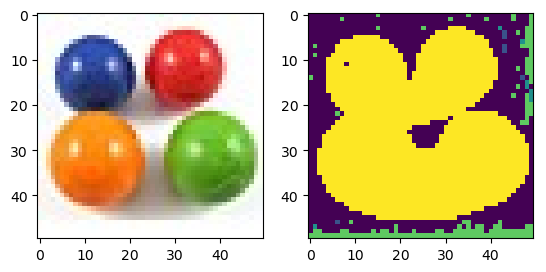

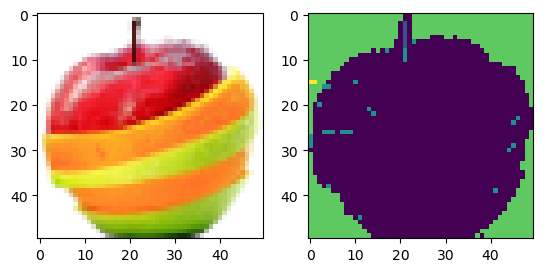

In [153]:
image_segmentation(input_img='four_elements.bmp', k=5, num_classes=5, laplacian_normalization='sym')
image_segmentation(input_img='fruit_salad.bmp', k=2, num_classes=5)

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

**Answer Q3.2**

*  **Sparse Matrix:** As we use KNN graphs with $k << d$, where d is the dimension of the image, the Laplacian matrix is very sparse. This sparsity can be leveraged to reduce the storage and computational cost of spectral clustering. For example, the Laplacian matrix can be stored using 'scipy.sparse' and the 'scipy.sparse.linalg.eigs()' function can be used to compute the eigenvectors and eigenvalues.

*  **Downsampling:** A simple method to reduce memory and computational cost is to downsample the image and perform spectral clustering on the downsampled image. The resulting segmentation map is then upsampled to match the original image size, and smoothing is applied to avoid pixelization along the shape borders. Different filtering techniques such as Gaussian filtering or Bilateral filtering (which takes into account the intensity of the original image) can be used to perform the smoothing.

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

In [47]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs

In [192]:
def display(Xs):
    fig = plt.figure(figsize=(10*len(Xs), 10))
    idx = 1
    for X in Xs:
        fig.add_subplot(1, len(Xs), idx)
        plt.imshow(X)
        idx += 1
    plt.show()


def downsample(X, factor):
    w, h, c = X.shape
    X_down = np.zeros((w//factor, h//factor, c))
    for i in range(w//factor):
        for j in range(h//factor):
            X_down[i,j,:] = X[i*factor, j*factor, :]
    return X_down

def upsample(Yr_down, factor, W_init, H_init):
    w_down, h_dow = Yr_down.shape
    Yr = np.zeros((W_init, H_init))
    for i in range(W_init):
        for j in range(H_init):
            if i//factor < Yr_down.shape[0] and j//factor < Yr_down.shape[1]:
                Yr[i, j] = Yr_down[i//factor, j//factor]
    return Yr

In [ ]:
# Download image
input_img = 'hand.jpg'
filename = os.path.join('data', input_img)

X_init = io.imread(filename)

# Normalize the values
X_init = (X_init - np.min(X_init)) / (np.max(X_init) - np.min(X_init))
W_init, H_init, _ = X_init.shape

# Clustering parameters
num_classes = 2

# Downsample image
factor = 10

print("Downsample image by a factor of {}...".format(factor))
X_down = downsample(X_init, factor)
print("Done")
display([X_init, X_down])

W_down, H_down, _ = X_down.shape
Xr = X_down.reshape(W_down * H_down, 3)

# Construct graph
k = 70
print("Building the similarity graph (k={}) ...".format(k))
W = build_similarity_graph(Xr, var=var, k=k)
L = build_laplacian(W, laplacian_normalization='sym')
print("Done")

# Sparse matrix
sparse_L = csr_matrix(L)
# Compute the (num_classes + 1) first eigenvalues and eigenvectors of the sparse matrix
print("Computing the {} smallest eigenvalues and associated eigenvectors ...".format(num_classes+1))
eig_values, eig_vectors = eigs(sparse_L, k=num_classes+2, which='SM')
print("Done")

sort_idx = np.argsort(eig_values)
U = np.real(eig_vectors[:, sort_idx])
E = np.real(eig_values[sort_idx])

# Identify eigenvalue gap
gap_idx =identify_gap(E, num_classes+1)
idxs = np.arange(0, gap_idx+1)

# Compute the clustering on the corresponding eigenvectors
print("Kmeans on the selected eigenvectors...")
Yr_down = KMeans(num_classes).fit_predict(U[:,idxs])
print("Done")
Yr_down = Yr_down.reshape(W_down, H_down)

display([X_down, Yr_down])

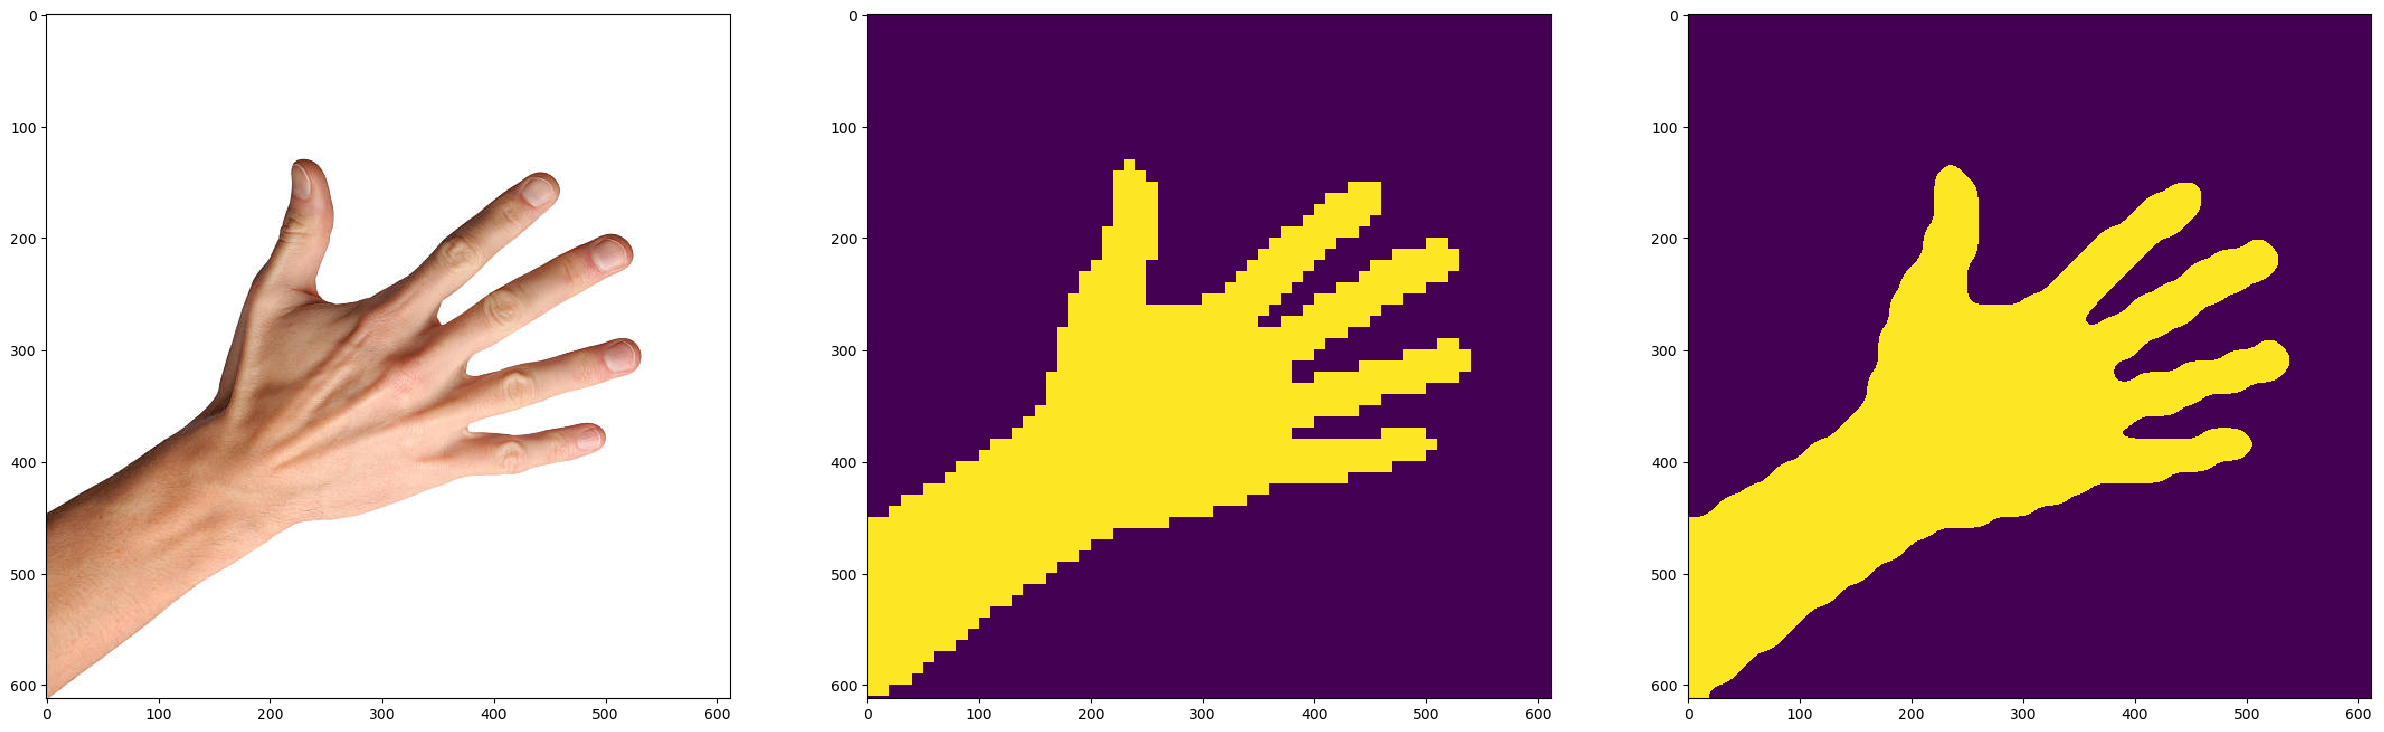

In [200]:
import cv2

Yr = upsample(Yr_down, factor, W_init, H_init)
kernel_size = 45
Yr_smooth = cv2.GaussianBlur(Yr.astype(np.uint8),(kernel_size, kernel_size),0)
display([X_init, Yr, Yr_smooth])

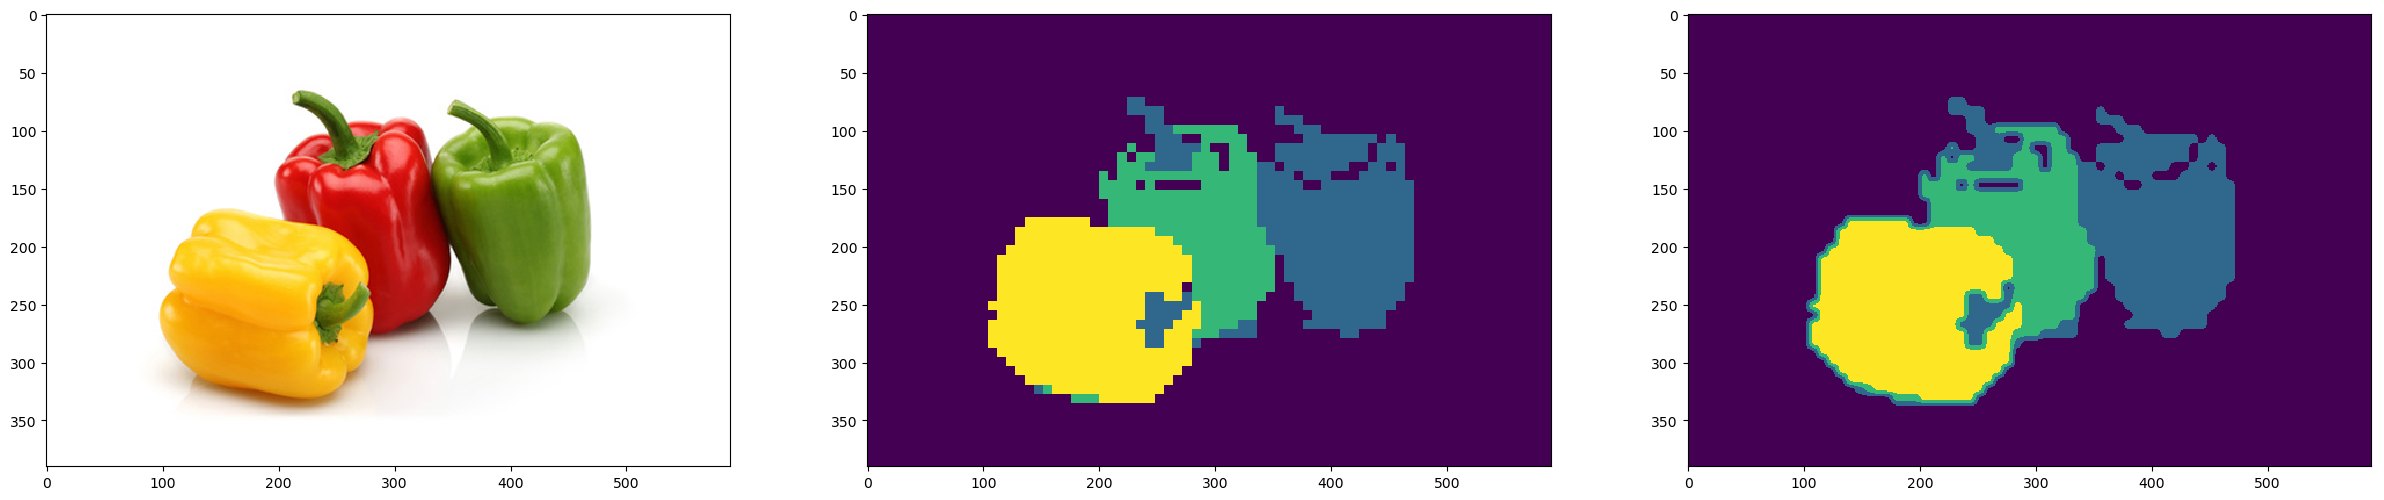

In [193]:
import cv2

Yr = upsample(Yr_down, factor, W_init, H_init)
kernel_size = 15
Yr_smooth = cv2.GaussianBlur(Yr.astype(np.uint8),(kernel_size, kernel_size),0)
display([X_init, Yr, Yr_smooth])

**Answers Q3.3**
We have observed that this method provides relatively good results on images with higher dimensions. The 'hand' image was downsized by a factor of 10 and then a Gaussian filter with a kernel size of 45 was applied. The 'peppers' image was downsized by a factor of 8 and a Gaussian filter with a kernel size of 15 was applied. Both outputs were computed on KNN graphs with k=70.

However, for images of size approximately 1000x1000, the downsizing factor has to be around 20. The higher the downsizing factor, the more information, especially details, are lost. As a result, this method can only be applied to images with low detail, such as the 'hand' image.

Another drawback of this method in image segmentation is that it does not take into account the spatial information. The similarity graph is solely based on the color intensity of the pixels. For proper segmentation, clustering should encourage adjacent pixels to belong to the same cluster, which would prevent misclustering, like the reflections in the 'fruit_salad' and 'peppers' images.

In the first semester course of 3D computer vision, we have implemented a method for image segmentation also based on graph cuts. However, this method takes into account both the location and intensity of the pixels. On an oriented graph, the arcs connect neighboring pixels and have for weights the intensity similarity (like in spectral clustering). This method requires less memory storage as the graph is smaller and takes spatial information into account. Hence, I believe it is a more appropriate method for image segmentation.